<a href="https://colab.research.google.com/github/larubiano0/Parcial2-He2AI/blob/main/GDP_script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Parcial 2 - Inteligencia Artificial

#Datos

##Importación librerías

In [1]:
import kagglehub
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from tensorflow import keras
from tensorflow.keras import layers
import shap

##Carga base de datos

In [2]:
path = kagglehub.dataset_download("sazidthe1/world-gdp-data")

print("Path to dataset files:", path)
country_codes = pd.read_csv(os.path.join(path, 'country_codes.csv'))
gdp_data = pd.read_csv(os.path.join(path, 'gdp_data.csv'))

100%|██████████| 108k/108k [00:00<00:00, 295kB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/sazidthe1/world-gdp-data/versions/1


##Datos

In [3]:
country_codes.head()

,country_code,region,income_group
0,ABW,Latin America & Caribbean,High income
1,AFG,South Asia,Low income
2,AGO,Sub-Saharan Africa,Lower middle income
3,ALB,Europe & Central Asia,Upper middle income
4,AND,Europe & Central Asia,High income


In [4]:
gdp_data.head()

,country_name,country_code,year,value
0,Afghanistan,AFG,1960,537777811.1
1,Afghanistan,AFG,1961,548888895.6
2,Afghanistan,AFG,1962,546666677.8
3,Afghanistan,AFG,1963,751111191.1
4,Afghanistan,AFG,1964,800000044.4


##Ordenar información

In [5]:
# Transformar la base al formato ancho, manteniendo la columna country_code
gdp_data_pivot = gdp_data.pivot(index=["country_name", "country_code"], columns="year", values="value")

# Opcional: Resetear el índice si deseas que el país sea una columna normal
gdp_data_pivot.reset_index(inplace=True)

# Renombrar indice a index

gdp_data_pivot.rename_axis(None, axis=1, inplace=True)

gdp_data_pivot.head()

,country_name,country_code,1960,1961,1962,1963,1964,1965,1966,1967,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Afghanistan,AFG,5.377778e+08,5.488889e+08,5.466667e+08,7.511112e+08,8.000000e+08,1.006667e+09,1.400000e+09,1.673333e+09,...,2.056449e+10,2.055058e+10,1.999814e+10,1.801955e+10,1.889635e+10,1.841886e+10,1.890450e+10,2.014345e+10,1.458314e+10,NaN
1,Africa Eastern and Southern,AFE,2.112502e+10,2.161623e+10,2.350628e+10,2.804836e+10,2.592067e+10,2.947210e+10,3.201437e+10,3.326951e+10,...,9.860000e+11,1.010000e+12,9.270000e+11,8.850000e+11,1.020000e+12,1.010000e+12,1.000000e+12,9.280000e+11,1.080000e+12,1.170000e+12
2,Africa Western and Central,AFW,1.044764e+10,1.117321e+10,1.199053e+10,1.272769e+10,1.389811e+10,1.492979e+10,1.591084e+10,1.451058e+10,...,8.340000e+11,8.940000e+11,7.690000e+11,6.910000e+11,6.850000e+11,7.670000e+11,8.230000e+11,7.860000e+11,8.440000e+11,8.780000e+11
3,Albania,ALB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.277622e+10,1.322815e+10,1.138685e+10,1.186120e+10,1.301973e+10,1.515642e+10,1.540183e+10,1.516273e+10,1.793057e+10,1.888210e+10
4,Algeria,DZA,2.723615e+09,2.434747e+09,2.001445e+09,2.702982e+09,2.909316e+09,3.136284e+09,3.039859e+09,3.370870e+09,...,2.100000e+11,2.140000e+11,1.660000e+11,1.600000e+11,1.700000e+11,1.750000e+11,1.720000e+11,1.460000e+11,1.630000e+11,1.920000e+11


##Agregar otra base de datos

In [6]:
# Unir gdp_data_pivot con country_codes para agregar las columnas 'region' e 'income_group'
gdp_data_pivot = gdp_data_pivot.merge(country_codes, on='country_code', how='left')

# Reordenar las columnas para colocar 'region' e 'income_group' justo después de 'country_code'
cols = list(gdp_data_pivot.columns)
cols.insert(2, cols.pop(cols.index('region')))
cols.insert(3, cols.pop(cols.index('income_group')))
gdp_data_pivot = gdp_data_pivot[cols]

gdp_data_pivot.head()

,country_name,country_code,region,income_group,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Afghanistan,AFG,South Asia,Low income,5.377778e+08,5.488889e+08,5.466667e+08,7.511112e+08,8.000000e+08,1.006667e+09,...,2.056449e+10,2.055058e+10,1.999814e+10,1.801955e+10,1.889635e+10,1.841886e+10,1.890450e+10,2.014345e+10,1.458314e+10,NaN
1,Africa Eastern and Southern,AFE,NaN,NaN,2.112502e+10,2.161623e+10,2.350628e+10,2.804836e+10,2.592067e+10,2.947210e+10,...,9.860000e+11,1.010000e+12,9.270000e+11,8.850000e+11,1.020000e+12,1.010000e+12,1.000000e+12,9.280000e+11,1.080000e+12,1.170000e+12
2,Africa Western and Central,AFW,NaN,NaN,1.044764e+10,1.117321e+10,1.199053e+10,1.272769e+10,1.389811e+10,1.492979e+10,...,8.340000e+11,8.940000e+11,7.690000e+11,6.910000e+11,6.850000e+11,7.670000e+11,8.230000e+11,7.860000e+11,8.440000e+11,8.780000e+11
3,Albania,ALB,Europe & Central Asia,Upper middle income,NaN,NaN,NaN,NaN,NaN,NaN,...,1.277622e+10,1.322815e+10,1.138685e+10,1.186120e+10,1.301973e+10,1.515642e+10,1.540183e+10,1.516273e+10,1.793057e+10,1.888210e+10
4,Algeria,DZA,Middle East & North Africa,Lower middle income,2.723615e+09,2.434747e+09,2.001445e+09,2.702982e+09,2.909316e+09,3.136284e+09,...,2.100000e+11,2.140000e+11,1.660000e+11,1.600000e+11,1.700000e+11,1.750000e+11,1.720000e+11,1.460000e+11,1.630000e+11,1.920000e+11


##Quitar países

In [7]:
# Quitar países que no sean países, es decir, aquellos con valor NaN en 'region'
gdp_data_pivot = gdp_data_pivot[gdp_data_pivot['region'].notnull()]
# Resetear el índice para que quede consecutivo tras eliminar filas
gdp_data_pivot.reset_index(drop=True, inplace=True)
# Calcular el número de países restantes y mostrarlo
n = len(gdp_data_pivot)
print("Number of countries:", n)
# Mostrar las primeras filas del DataFrame resultante
gdp_data_pivot.head()

Number of countries: 214


,country_name,country_code,region,income_group,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Afghanistan,AFG,South Asia,Low income,5.377778e+08,5.488889e+08,5.466667e+08,7.511112e+08,8.000000e+08,1.006667e+09,...,2.056449e+10,2.055058e+10,1.999814e+10,1.801955e+10,1.889635e+10,1.841886e+10,1.890450e+10,2.014345e+10,1.458314e+10,NaN
1,Albania,ALB,Europe & Central Asia,Upper middle income,NaN,NaN,NaN,NaN,NaN,NaN,...,1.277622e+10,1.322815e+10,1.138685e+10,1.186120e+10,1.301973e+10,1.515642e+10,1.540183e+10,1.516273e+10,1.793057e+10,1.888210e+10
2,Algeria,DZA,Middle East & North Africa,Lower middle income,2.723615e+09,2.434747e+09,2.001445e+09,2.702982e+09,2.909316e+09,3.136284e+09,...,2.100000e+11,2.140000e+11,1.660000e+11,1.600000e+11,1.700000e+11,1.750000e+11,1.720000e+11,1.460000e+11,1.630000e+11,1.920000e+11
3,American Samoa,ASM,East Asia & Pacific,High income,NaN,NaN,NaN,NaN,NaN,NaN,...,6.380000e+08,6.430000e+08,6.730000e+08,6.710000e+08,6.120000e+08,6.390000e+08,6.470000e+08,7.160000e+08,7.090000e+08,NaN
4,Andorra,AND,Europe & Central Asia,High income,NaN,NaN,NaN,NaN,NaN,NaN,...,3.193513e+09,3.271686e+09,2.789881e+09,2.896610e+09,3.000162e+09,3.218420e+09,3.155149e+09,2.891001e+09,3.325145e+09,3.352033e+09


##Gráficar missing values

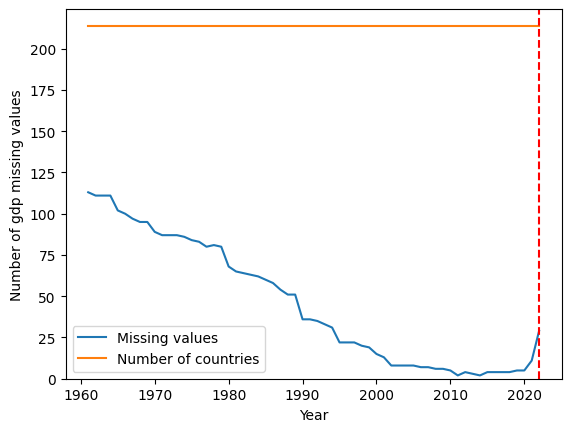

In [8]:
#Se usa isna().sum() para contar cuántos valores NaN hay en cada columna.
#Luego, se transforma el resultado en una lista con .tolist().
#[5:] omite las primeras 5 columnas (las no relacionadas directamente con los años, por ejemplo: country_name, country_code, region, income_group, etc.) y se asume que a partir del índice 5 comienzan las columnas de años.

nan_counts_per_year = gdp_data_pivot.isna().sum().tolist()[5:]
#Ajusta el eje Y para que inicie en 0 y vaya hasta un valor ligeramente mayor que el número total de países n. De esta forma, la línea que indica la cantidad de países no se sale del gráfico.
plt.ylim(0, n+10)
#Se trazan en el eje X las columnas (que deberían ser los años) y en el eje Y la cantidad de valores faltantes correspondientes a cada año.
plt.plot(gdp_data_pivot.columns[5:], nan_counts_per_year)
#Se añaden etiquetas descriptivas a los ejes.
plt.xlabel('Year')
plt.ylabel('Number of gdp missing values')
#Se dibuja una línea horizontal que representa el total de países (n) para cada año, con el fin de comparar visualmente la cantidad de valores faltantes frente al total de países.
plt.plot(gdp_data_pivot.columns[5:], [n] * len(gdp_data_pivot.columns[5:]))
plt.axvline(x=2022, color='r', linestyle='--')
plt.legend(['Missing values', 'Number of countries'])

##Borrar años con varios missing values

In [9]:
#Se eliminan las columnas correspondientes a los años 1961 a 1989. Sin embargo, al usar gdp_data_pivot.columns[4:34], se están tomando las columnas desde el índice 4 (inclusive) hasta el 33 (inclusive).
#Esto significa que la columna 1960 también es eliminada, aunque el comentario solo mencione 1961 a 1989. El resultado final es que en el DataFrame permanecen las columnas desde 1990 en adelante (además de las de identificación: country_name, country_code, region, income_group).
gdp_data_pivot.drop(gdp_data_pivot.columns[4:34], axis=1, inplace=True)
gdp_data_pivot

,country_name,country_code,region,income_group,1990,1991,1992,1993,1994,1995,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
0,Afghanistan,AFG,South Asia,Low income,NaN,NaN,NaN,NaN,NaN,NaN,...,2.056449e+10,2.055058e+10,1.999814e+10,1.801955e+10,1.889635e+10,1.841886e+10,1.890450e+10,2.014345e+10,1.458314e+10,NaN
1,Albania,ALB,Europe & Central Asia,Upper middle income,2.028554e+09,1.099559e+09,6.521750e+08,1.185315e+09,1.880951e+09,2.392765e+09,...,1.277622e+10,1.322815e+10,1.138685e+10,1.186120e+10,1.301973e+10,1.515642e+10,1.540183e+10,1.516273e+10,1.793057e+10,1.888210e+10
2,Algeria,DZA,Middle East & North Africa,Lower middle income,6.204851e+10,4.571568e+10,4.800313e+10,4.994559e+10,4.254318e+10,4.176429e+10,...,2.100000e+11,2.140000e+11,1.660000e+11,1.600000e+11,1.700000e+11,1.750000e+11,1.720000e+11,1.460000e+11,1.630000e+11,1.920000e+11
3,American Samoa,ASM,East Asia & Pacific,High income,NaN,NaN,NaN,NaN,NaN,NaN,...,6.380000e+08,6.430000e+08,6.730000e+08,6.710000e+08,6.120000e+08,6.390000e+08,6.470000e+08,7.160000e+08,7.090000e+08,NaN
4,Andorra,AND,Europe & Central Asia,High income,1.028989e+09,1.106891e+09,1.209993e+09,1.007091e+09,1.017545e+09,1.178745e+09,...,3.193513e+09,3.271686e+09,2.789881e+09,2.896610e+09,3.000162e+09,3.218420e+09,3.155149e+09,2.891001e+09,3.325145e+09,3.352033e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,Virgin Islands (U.S.),VIR,Latin America & Caribbean,High income,NaN,NaN,NaN,NaN,NaN,NaN,...,3.738000e+09,3.565000e+09,3.663000e+09,3.798000e+09,3.794000e+09,3.922000e+09,4.117000e+09,4.204000e+09,NaN,NaN
210,West Bank and Gaza,PSE,Middle East & North Africa,Upper middle income,NaN,NaN,NaN,NaN,2.843300e+09,3.282800e+09,...,1.351550e+10,1.398970e+10,1.397240e+10,1.540540e+10,1.612800e+10,1.627660e+10,1.713350e+10,1.553170e+10,1.810900e+10,1.911190e+10
211,"Yemen, Rep.",YEM,Middle East & North Africa,Low income,5.647119e+09,5.930370e+09,6.463650e+09,5.368271e+09,4.167356e+09,4.258789e+09,...,4.041523e+10,4.322859e+10,4.244449e+10,3.131782e+10,2.684223e+10,2.160616e+10,NaN,NaN,NaN,NaN
212,Zambia,ZMB,Sub-Saharan Africa,Lower middle income,3.285217e+09,3.376807e+09,3.181922e+09,3.273508e+09,3.656808e+09,3.806983e+09,...,2.803724e+10,2.714102e+10,2.125122e+10,2.095841e+10,2.587360e+10,2.631151e+10,2.330867e+10,1.811064e+10,2.214765e+10,2.978445e+10


##Agregar expectativa de vida a los datos

In [10]:
# Se descarga y carga la base de datos de expectativa de vida
path = kagglehub.dataset_download("iamsouravbanerjee/life-expectancy-at-birth-across-the-globe")
print("Path to dataset files:", path)
life_expectancy = pd.read_csv(os.path.join(path, 'Life Expectancy at Birth.csv'))
life_expectancy.head()

100%|██████████| 25.1k/25.1k [00:00<00:00, 5.72MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/iamsouravbanerjee/life-expectancy-at-birth-across-the-globe/versions/2


,ISO3,Country,Continent,Hemisphere,Human Development Groups,UNDP Developing Regions,HDI Rank (2021),Life Expectancy at Birth (1990),Life Expectancy at Birth (1991),Life Expectancy at Birth (1992),...,Life Expectancy at Birth (2012),Life Expectancy at Birth (2013),Life Expectancy at Birth (2014),Life Expectancy at Birth (2015),Life Expectancy at Birth (2016),Life Expectancy at Birth (2017),Life Expectancy at Birth (2018),Life Expectancy at Birth (2019),Life Expectancy at Birth (2020),Life Expectancy at Birth (2021)
0,AFG,Afghanistan,Asia,Northern Hemisphere,Low,SA,180.0,45.9672,46.6631,47.5955,...,61.9230,62.4167,62.5451,62.6587,63.1361,63.0160,63.0810,63.5645,62.5751,61.9824
1,AGO,Angola,Africa,Southern Hemisphere,Medium,SSA,148.0,41.8933,43.8127,42.2088,...,58.6231,59.3074,60.0397,60.6546,61.0923,61.6798,62.1438,62.4484,62.2612,61.6434
2,ALB,Albania,Europe,Northern Hemisphere,High,ECA,67.0,73.1439,73.3776,73.7148,...,78.0640,78.1226,78.4075,78.6441,78.8602,79.0473,79.1838,79.2825,76.9893,76.4626
3,AND,Andorra,Europe,Northern Hemisphere,Very High,NaN,40.0,78.4063,77.9805,80.3241,...,82.9166,82.9343,82.9483,82.9534,82.9671,82.9803,82.9923,83.0039,79.0234,80.3684
4,ARE,United Arab Emirates,Asia,Northern Hemisphere,Very High,AS,26.0,71.9004,72.2414,72.3062,...,78.7155,78.8528,79.0442,79.2232,79.3347,79.5036,79.6274,79.7262,78.9457,78.7104


##Ordenar información

In [11]:
# Unir gdp_data_pivot con life_expectancy para agregar las columnas requeridas
gdp_data_pivot = gdp_data_pivot.merge(life_expectancy, left_on='country_code', right_on='ISO3', how='left')


# Definir las columnas adicionales a agregar
additional_columns = ["Continent", "Hemisphere", "Human Development Groups", "HDI Rank (2021)"]
life_expectancy_columns = [f"Life Expectancy at Birth ({year})" for year in range(1990, 2022)]

# Reordenar las columnas para colocar las columnas adicionales justo después de 'income_group'
cols = list(gdp_data_pivot.columns)
for col in additional_columns:
    cols.insert(cols.index('income_group') + 1, cols.pop(cols.index(col)))

# Reordenar las columnas para colocar las columnas de expectativa de vida justo después del año correspondiente
for year in range(1990, 2022):
    cols.insert(cols.index(year) + 1, cols.pop(cols.index(f"Life Expectancy at Birth ({year})")))

# Aplicar el nuevo orden de columnas al DataFrame
gdp_data_pivot = gdp_data_pivot[cols]

# Eliminar las últimas 3 columnas
gdp_data_pivot.drop(gdp_data_pivot.columns[-3:], axis=1, inplace=True)

gdp_data_pivot

,country_name,country_code,region,income_group,HDI Rank (2021),Human Development Groups,Hemisphere,Continent,1990,Life Expectancy at Birth (1990),...,Life Expectancy at Birth (2017),2018,Life Expectancy at Birth (2018),2019,Life Expectancy at Birth (2019),2020,Life Expectancy at Birth (2020),2021,Life Expectancy at Birth (2021),2022
0,Afghanistan,AFG,South Asia,Low income,180.0,Low,Northern Hemisphere,Asia,NaN,45.9672,...,63.0160,1.841886e+10,63.0810,1.890450e+10,63.5645,2.014345e+10,62.5751,1.458314e+10,61.9824,NaN
1,Albania,ALB,Europe & Central Asia,Upper middle income,67.0,High,Northern Hemisphere,Europe,2.028554e+09,73.1439,...,79.0473,1.515642e+10,79.1838,1.540183e+10,79.2825,1.516273e+10,76.9893,1.793057e+10,76.4626,1.888210e+10
2,Algeria,DZA,Middle East & North Africa,Lower middle income,91.0,High,Northern Hemisphere,Africa,6.204851e+10,67.4160,...,75.7428,1.750000e+11,76.0656,1.720000e+11,76.4742,1.460000e+11,74.4528,1.630000e+11,76.3767,1.920000e+11
3,American Samoa,ASM,East Asia & Pacific,High income,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,6.390000e+08,NaN,6.470000e+08,NaN,7.160000e+08,NaN,7.090000e+08,NaN,NaN
4,Andorra,AND,Europe & Central Asia,High income,40.0,Very High,Northern Hemisphere,Europe,1.028989e+09,78.4063,...,82.9803,3.218420e+09,82.9923,3.155149e+09,83.0039,2.891001e+09,79.0234,3.325145e+09,80.3684,3.352033e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,Virgin Islands (U.S.),VIR,Latin America & Caribbean,High income,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.922000e+09,NaN,4.117000e+09,NaN,4.204000e+09,NaN,NaN,NaN,NaN
210,West Bank and Gaza,PSE,Middle East & North Africa,Upper middle income,106.0,High,Northern Hemisphere,Asia,NaN,67.9337,...,74.8329,1.627660e+10,74.7930,1.713350e+10,75.2406,1.553170e+10,74.4035,1.810900e+10,73.4727,1.911190e+10
211,"Yemen, Rep.",YEM,Middle East & North Africa,Low income,183.0,Low,Northern Hemisphere,Asia,5.647119e+09,58.6994,...,65.9573,2.160616e+10,64.5751,NaN,65.0917,NaN,64.6501,NaN,63.7534,NaN
212,Zambia,ZMB,Sub-Saharan Africa,Lower middle income,154.0,Medium,Southern Hemisphere,Africa,3.285217e+09,47.9263,...,62.1201,2.631151e+10,62.3422,2.330867e+10,62.7926,1.811064e+10,62.3803,2.214765e+10,61.2234,2.978445e+10


In [12]:
#Extrae y muestra los valores únicos de las variables categóricas para validar la integridad y consistencia de los datos.

unique_income_group = gdp_data_pivot['income_group'].unique()
unique_human_development_groups = gdp_data_pivot['Human Development Groups'].unique()
unique_hemisphere = gdp_data_pivot['Hemisphere'].unique()
unique_continent = gdp_data_pivot['Continent'].unique()
unique_region = gdp_data_pivot['region'].unique()

print("Unique values for income_group:", unique_income_group)
print("Unique values for Human Development Groups:", unique_human_development_groups)
print("Unique values for Hemisphere:", unique_hemisphere)
print("Unique values for Continent:", unique_continent)
print("Unique values for Region:", unique_region)

Unique values for income_group: ['Low income' 'Upper middle income' 'Lower middle income' 'High income']
Unique values for Human Development Groups: ['Low' 'High' nan 'Very High' 'Medium']
Unique values for Hemisphere: ['Northern Hemisphere' nan 'Southern Hemisphere']
Unique values for Continent: ['Asia' 'Europe' 'Africa' nan 'America' 'Oceania']
Unique values for Region: ['South Asia' 'Europe & Central Asia' 'Middle East & North Africa'
 'East Asia & Pacific' 'Sub-Saharan Africa' 'Latin America & Caribbean'
 'North America']


In [13]:
# Interpolar los datos del PIB
gdp_columns = list(range(1990, 2023))
# Primero, interpola como antes:
gdp_data_pivot[gdp_columns] = gdp_data_pivot[gdp_columns].interpolate(axis=1, limit_direction='both')

# Luego, llena cualquier valor NaN restante usando el método de llenado hacia adelante (forward fill) y hacia atrás (backward fill):
gdp_data_pivot[gdp_columns] = gdp_data_pivot[gdp_columns].fillna(method='ffill').fillna(method='bfill')


# Interpolar los datos de Esperanza de Vida al Nacer
gdp_data_pivot[life_expectancy_columns] = gdp_data_pivot[life_expectancy_columns].interpolate(axis=1, limit_direction='both')
gdp_data_pivot[life_expectancy_columns] = gdp_data_pivot[life_expectancy_columns].fillna(method='ffill').fillna(method='bfill')
#Entonces, se innterpola los datos del PIB y de la expectativa de vida a lo largo de los años, completando los valores faltantes mediante interpolación horizontal y llenado hacia adelante y hacia atrás.

# Mostrar el dataframe actualizado
gdp_data_pivot.head()

<ipython-input-13-e4e5d990d0b8>:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gdp_data_pivot[gdp_columns] = gdp_data_pivot[gdp_columns].fillna(method='ffill').fillna(method='bfill')
<ipython-input-13-e4e5d990d0b8>:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gdp_data_pivot[life_expectancy_columns] = gdp_data_pivot[life_expectancy_columns].fillna(method='ffill').fillna(method='bfill')


,country_name,country_code,region,income_group,HDI Rank (2021),Human Development Groups,Hemisphere,Continent,1990,Life Expectancy at Birth (1990),...,Life Expectancy at Birth (2017),2018,Life Expectancy at Birth (2018),2019,Life Expectancy at Birth (2019),2020,Life Expectancy at Birth (2020),2021,Life Expectancy at Birth (2021),2022
0,Afghanistan,AFG,South Asia,Low income,180.0,Low,Northern Hemisphere,Asia,3.854235e+09,45.9672,...,63.0160,1.841886e+10,63.0810,1.890450e+10,63.5645,2.014345e+10,62.5751,1.458314e+10,61.9824,1.458314e+10
1,Albania,ALB,Europe & Central Asia,Upper middle income,67.0,High,Northern Hemisphere,Europe,2.028554e+09,73.1439,...,79.0473,1.515642e+10,79.1838,1.540183e+10,79.2825,1.516273e+10,76.9893,1.793057e+10,76.4626,1.888210e+10
2,Algeria,DZA,Middle East & North Africa,Lower middle income,91.0,High,Northern Hemisphere,Africa,6.204851e+10,67.4160,...,75.7428,1.750000e+11,76.0656,1.720000e+11,76.4742,1.460000e+11,74.4528,1.630000e+11,76.3767,1.920000e+11
3,American Samoa,ASM,East Asia & Pacific,High income,NaN,NaN,NaN,NaN,5.120000e+08,67.4160,...,75.7428,6.390000e+08,76.0656,6.470000e+08,76.4742,7.160000e+08,74.4528,7.090000e+08,76.3767,7.090000e+08
4,Andorra,AND,Europe & Central Asia,High income,40.0,Very High,Northern Hemisphere,Europe,1.028989e+09,78.4063,...,82.9803,3.218420e+09,82.9923,3.155149e+09,83.0039,2.891001e+09,79.0234,3.325145e+09,80.3684,3.352033e+09


In [14]:
# Eliminar las columnas especificadas y reemplazarlas con codificación one-hot
columns_to_encode = ['region', 'income_group', 'Human Development Groups', 'Hemisphere', 'Continent']
gdp_data_encoded = pd.get_dummies(gdp_data_pivot, columns=columns_to_encode, dummy_na=True)
gdp_data_encoded.head()

,country_name,country_code,HDI Rank (2021),1990,Life Expectancy at Birth (1990),1991,Life Expectancy at Birth (1991),1992,Life Expectancy at Birth (1992),1993,...,Human Development Groups_nan,Hemisphere_Northern Hemisphere,Hemisphere_Southern Hemisphere,Hemisphere_nan,Continent_Africa,Continent_America,Continent_Asia,Continent_Europe,Continent_Oceania,Continent_nan
0,Afghanistan,AFG,180.0,3.854235e+09,45.9672,3.854235e+09,46.6631,3.854235e+09,47.5955,3.854235e+09,...,False,True,False,False,False,False,True,False,False,False
1,Albania,ALB,67.0,2.028554e+09,73.1439,1.099559e+09,73.3776,6.521750e+08,73.7148,1.185315e+09,...,False,True,False,False,False,False,False,True,False,False
2,Algeria,DZA,91.0,6.204851e+10,67.4160,4.571568e+10,67.6875,4.800313e+10,67.7571,4.994559e+10,...,False,True,False,False,True,False,False,False,False,False
3,American Samoa,ASM,NaN,5.120000e+08,67.4160,5.120000e+08,67.6875,5.120000e+08,67.7571,5.120000e+08,...,True,False,False,True,False,False,False,False,False,True
4,Andorra,AND,40.0,1.028989e+09,78.4063,1.106891e+09,77.9805,1.209993e+09,80.3241,1.007091e+09,...,False,True,False,False,False,False,False,True,False,False


##Gráfica de dispersión

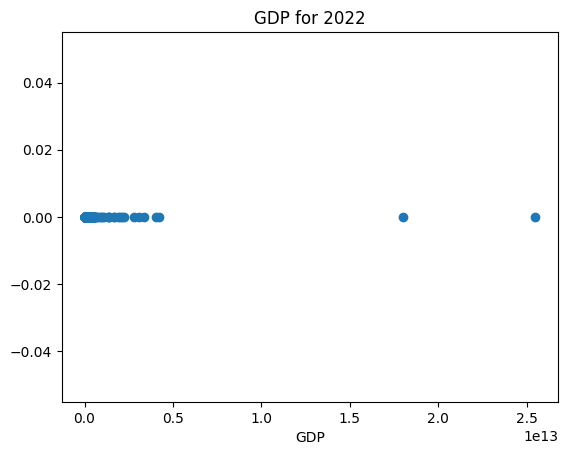

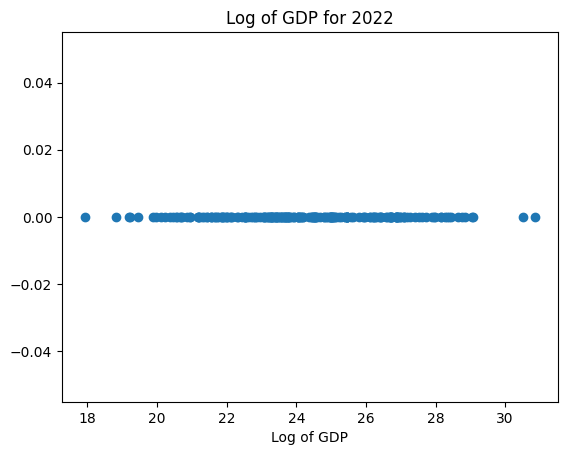

In [15]:
val = 0
ar1 = gdp_data_encoded[2022]
ar2 = np.log(gdp_data_encoded[2022])
# Gráfico 1: GDP 2022 en una sola dimensión (eje X)
plt.title('GDP for 2022')
plt.xlabel('GDP')
plt.plot(ar1, np.zeros_like(ar1) + val, 'o')
plt.show()
# Gráfico 2: Logaritmo de GDP 2022 en una sola dimensión (eje X)
plt.title('Log of GDP for 2022')
plt.xlabel('Log of GDP')
plt.plot(ar2, np.zeros_like(ar2) + val, 'o')
plt.show()
#Este método de graficar valores en y=0 es útil para obtener una representación 1D del PIB y su logaritmo, facilitando la detección de outliers y la comparación de distribuciones.

##Información final

In [16]:
cols = list(gdp_data_encoded.columns)
cols.append(cols.pop(cols.index(2022)))
gdp_data_encoded = gdp_data_encoded[cols]
# Calcular el logaritmo natural del PIB para 2022
gdp_data_encoded['ln_gdp_2022'] = np.log(gdp_data_encoded[2022])

# Calcular los umbrales para terciles (bajo, medio y alto)
lower_threshold = gdp_data_encoded['ln_gdp_2022'].quantile(1/3)
upper_threshold = gdp_data_encoded['ln_gdp_2022'].quantile(2/3)

# Crear variables dummy para cada uno de los tres grupos
gdp_data_encoded['gdp_2022_low'] = (gdp_data_encoded['ln_gdp_2022'] <= lower_threshold)
gdp_data_encoded['gdp_2022_middle'] = ((gdp_data_encoded['ln_gdp_2022'] > lower_threshold) & (gdp_data_encoded['ln_gdp_2022'] <= upper_threshold))
gdp_data_encoded['gdp_2022_high'] = (gdp_data_encoded['ln_gdp_2022'] > upper_threshold)

# Eliminar la columna original de 2022 y la columna de log
gdp_data_encoded.drop(columns=[2022, 'ln_gdp_2022'], inplace=True)

gdp_data_encoded.head()


<ipython-input-16-9fe150d5e7e3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdp_data_encoded['ln_gdp_2022'] = np.log(gdp_data_encoded[2022])
<ipython-input-16-9fe150d5e7e3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gdp_data_encoded['gdp_2022_low'] = (gdp_data_encoded['ln_gdp_2022'] <= lower_threshold)
<ipython-input-16-9fe150d5e7e3>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

,country_name,country_code,HDI Rank (2021),1990,Life Expectancy at Birth (1990),1991,Life Expectancy at Birth (1991),1992,Life Expectancy at Birth (1992),1993,...,Hemisphere_nan,Continent_Africa,Continent_America,Continent_Asia,Continent_Europe,Continent_Oceania,Continent_nan,gdp_2022_low,gdp_2022_middle,gdp_2022_high
0,Afghanistan,AFG,180.0,3.854235e+09,45.9672,3.854235e+09,46.6631,3.854235e+09,47.5955,3.854235e+09,...,False,False,False,True,False,False,False,False,True,False
1,Albania,ALB,67.0,2.028554e+09,73.1439,1.099559e+09,73.3776,6.521750e+08,73.7148,1.185315e+09,...,False,False,False,False,True,False,False,False,True,False
2,Algeria,DZA,91.0,6.204851e+10,67.4160,4.571568e+10,67.6875,4.800313e+10,67.7571,4.994559e+10,...,False,True,False,False,False,False,False,False,False,True
3,American Samoa,ASM,NaN,5.120000e+08,67.4160,5.120000e+08,67.6875,5.120000e+08,67.7571,5.120000e+08,...,True,False,False,False,False,False,True,True,False,False
4,Andorra,AND,40.0,1.028989e+09,78.4063,1.106891e+09,77.9805,1.209993e+09,80.3241,1.007091e+09,...,False,False,False,False,True,False,False,True,False,False


#Red neuronal

##Separar variables y "arreglar" errores

In [17]:
# Separar características y variable objetivo (se realiza drop de GDP y columnas de país)
X = gdp_data_encoded.drop(columns=['gdp_2022_low', 'gdp_2022_middle', 'gdp_2022_high', 'country_name', 'country_code'])
y = gdp_data_encoded[['gdp_2022_low', 'gdp_2022_middle', 'gdp_2022_high']]


# Reemplazar NaN con la media de cada columna
X = X.fillna(X.mean())

# Asegurar que los nombres de columnas sean strings
X.columns = X.columns.astype(str)

# Mostrar las variables que entran al modelo
print("Variables de entrada:", X.columns.tolist())


# Dividir en conjuntos de entrenamiento y prueba
# Se utiliza la etiqueta (índice de la clase) obtenido con argmax, ya que y está en formato one hot
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=41, stratify=y.values.argmax(axis=1)
)

# Escalar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Variables de entrada: ['HDI Rank (2021)', '1990', 'Life Expectancy at Birth (1990)', '1991', 'Life Expectancy at Birth (1991)', '1992', 'Life Expectancy at Birth (1992)', '1993', 'Life Expectancy at Birth (1993)', '1994', 'Life Expectancy at Birth (1994)', '1995', 'Life Expectancy at Birth (1995)', '1996', 'Life Expectancy at Birth (1996)', '1997', 'Life Expectancy at Birth (1997)', '1998', 'Life Expectancy at Birth (1998)', '1999', 'Life Expectancy at Birth (1999)', '2000', 'Life Expectancy at Birth (2000)', '2001', 'Life Expectancy at Birth (2001)', '2002', 'Life Expectancy at Birth (2002)', '2003', 'Life Expectancy at Birth (2003)', '2004', 'Life Expectancy at Birth (2004)', '2005', 'Life Expectancy at Birth (2005)', '2006', 'Life Expectancy at Birth (2006)', '2007', 'Life Expectancy at Birth (2007)', '2008', 'Life Expectancy at Birth (2008)', '2009', 'Life Expectancy at Birth (2009)', '2010', 'Life Expectancy at Birth (2010)', '2011', 'Life Expectancy at Birth (2011)', '2012', 'Lif

##Modelo y entrenamiento

In [18]:
# Definir el modelo base con learning_rate dinámico ('adaptive')
perceptron = MLPClassifier(
    hidden_layer_sizes=(50,),
    activation='logistic',    # Función de activación sigmoide
    solver='sgd',             # Descenso de gradiente estocástico
    learning_rate='adaptive', # Tasa de aprendizaje dinámica
    max_iter=5000,
    alpha=0.01,
    random_state=42
)

# Entrenar el modelo base
perceptron.fit(X_train_scaled, y_train)

# Evaluar el modelo base
# Se convierte la salida one hot a etiquetas usando argmax
y_pred = perceptron.predict(X_test_scaled)
accuracy = accuracy_score(y_test.values.argmax(axis=1), y_pred.argmax(axis=1))
print("Accuracy:", accuracy)
print(classification_report(y_test.values.argmax(axis=1), y_pred.argmax(axis=1)))

# Búsqueda de hiperparámetros ampliada, optimizando también sobre activación y solver
param_grid = {
    'hidden_layer_sizes': [(50, 50), (50, 50, 50), (50, 50, 50, 50)],
    'alpha': [0.0001, 0.01, 0.1],
    'max_iter': [5000],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.001, 0.01, 0.1],
    'activation': ['logistic', 'tanh', 'relu'],  # Funciones de activación a explorar
    'solver': ['sgd', 'adam', 'lbfgs']           # lbfgs utiliza un método cuasi-Newton
}

grid_search = GridSearchCV(
    MLPClassifier(random_state=42),
    param_grid,
    cv=3,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

# Mejor modelo obtenido
best_mlp = grid_search.best_estimator_
print("Mejores hiperparámetros:", grid_search.best_params_)

# Evaluación del mejor modelo obtenido (best_mlp) en el conjunto de prueba

# Realizamos las predicciones con el mejor modelo
y_pred_best = best_mlp.predict(X_test_scaled)

# Dado que el target está en formato one hot, convertimos tanto las predicciones como las etiquetas verdaderas a la clase correspondiente usando argmax
y_test_labels = y_test.values.argmax(axis=1)
y_pred_labels = y_pred_best.argmax(axis=1)

# Calculamos la accuracy
accuracy_best = accuracy_score(y_test_labels, y_pred_labels)
print("Accuracy del mejor modelo:", accuracy_best)

# Mostramos el reporte de clasificación con las métricas
print(classification_report(y_test_labels, y_pred_labels))

Accuracy: 0.5813953488372093
              precision    recall  f1-score   support

           0       0.48      0.80      0.60        15
           1       0.50      0.21      0.30        14
           2       0.83      0.71      0.77        14

    accuracy                           0.58        43
   macro avg       0.60      0.58      0.56        43
weighted avg       0.60      0.58      0.56        43

Mejores hiperparámetros: {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 5000, 'solver': 'adam'}
Accuracy del mejor modelo: 0.8604651162790697
              precision    recall  f1-score   support

           0       0.82      0.93      0.88        15
           1       0.91      0.71      0.80        14
           2       0.87      0.93      0.90        14

    accuracy                           0.86        43
   macro avg       0.87      0.86      0.86        43
weighted avg       

##Gráficos

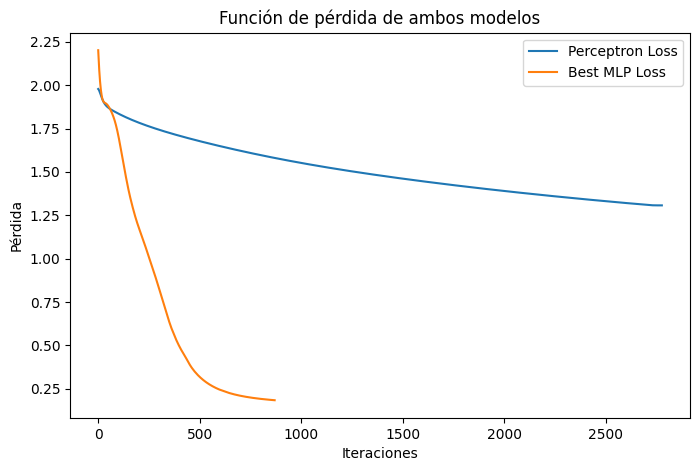

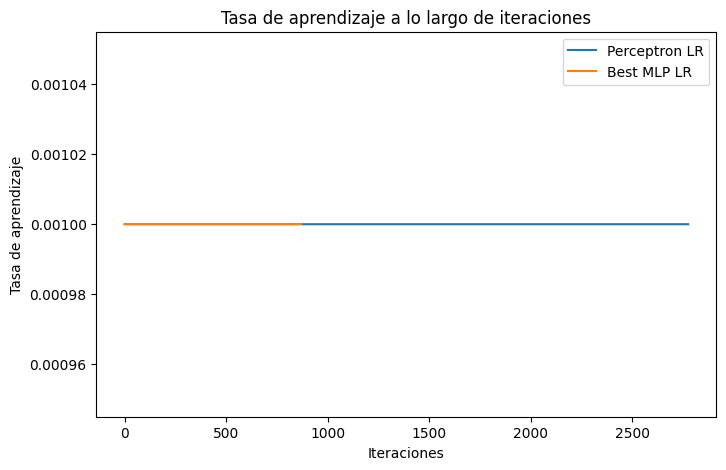

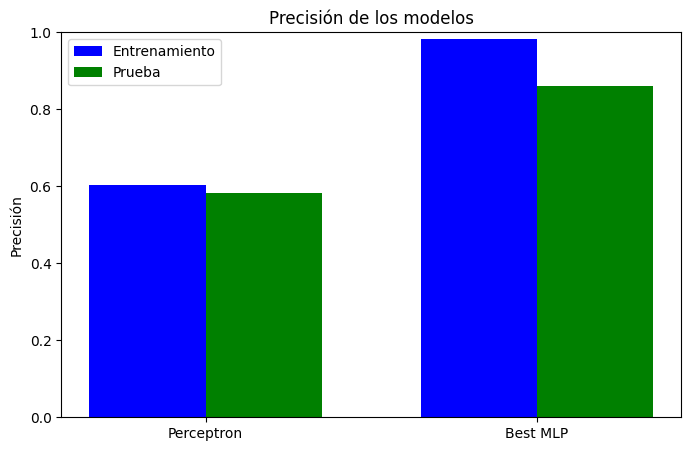

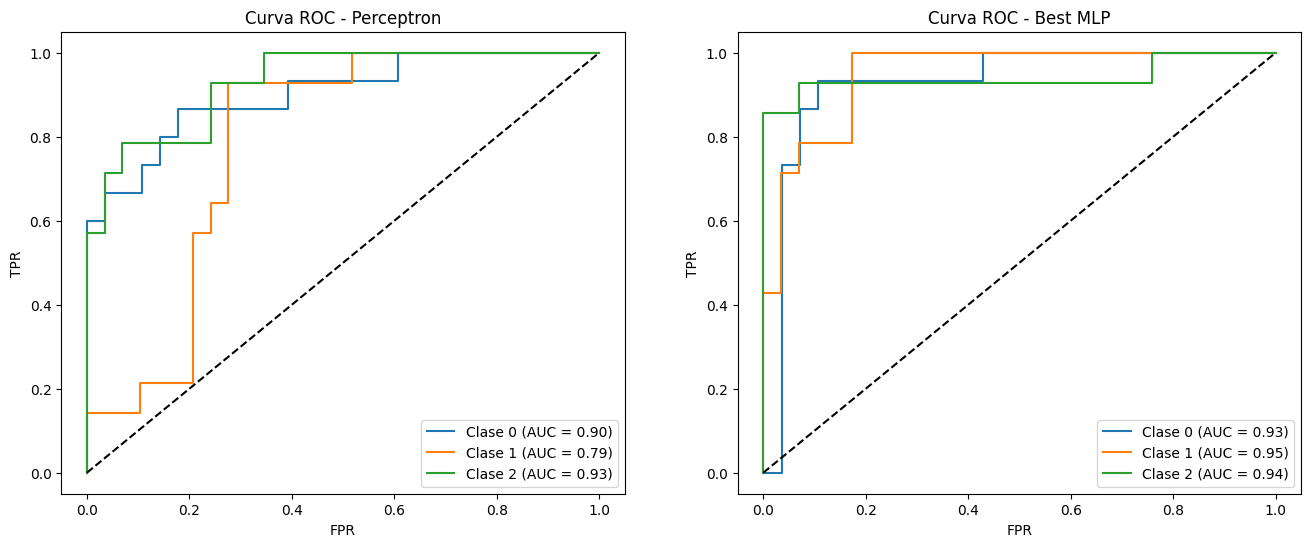

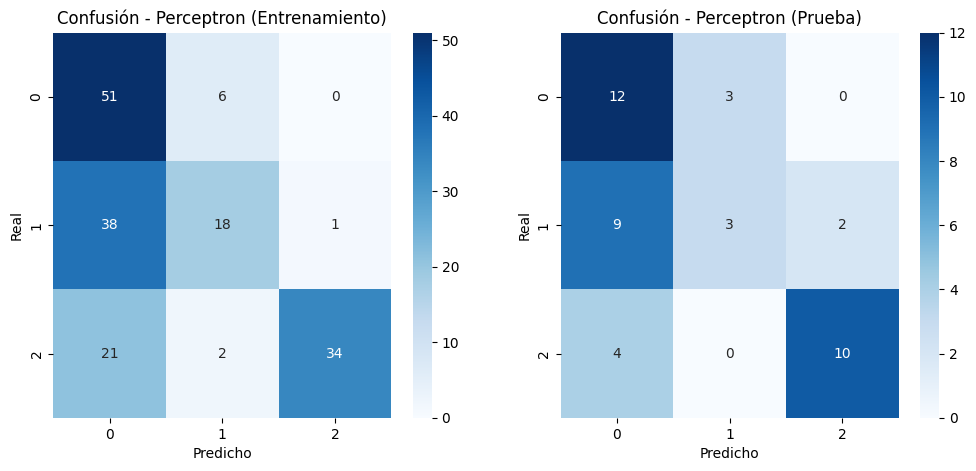

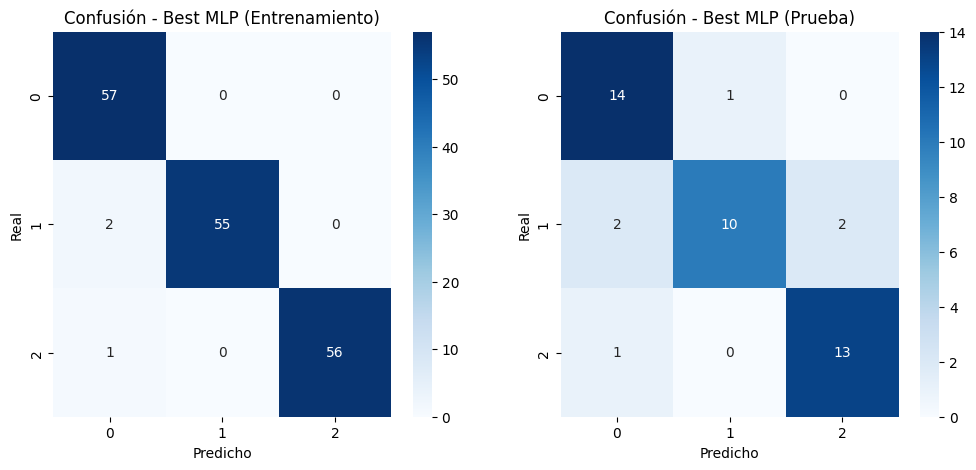

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score
from sklearn.preprocessing import label_binarize
import seaborn as sns

# -----------------------------
# 1. Función de pérdida y Learning Rate
# -----------------------------

plt.figure(figsize=(8, 5))
# Graficar loss_curve_ para el modelo "perceptron" si está disponible
if hasattr(perceptron, 'loss_curve_') and perceptron.loss_curve_:
    plt.plot(perceptron.loss_curve_, label='Perceptron Loss')
else:
    print("El modelo 'perceptron' no tiene loss_curve_ disponible.")

# Graficar loss_curve_ para el modelo "best_mlp" si está disponible
if hasattr(best_mlp, 'loss_curve_') and best_mlp.loss_curve_:
    plt.plot(best_mlp.loss_curve_, label='Best MLP Loss')
else:
    print("El modelo 'best_mlp' no tiene loss_curve_ disponible.")

plt.xlabel('Iteraciones')
plt.ylabel('Pérdida')
plt.title('Función de pérdida de ambos modelos')
plt.legend()
plt.show()

# Graficar la tasa de aprendizaje (se muestra como valor constante a lo largo de las iteraciones)
plt.figure(figsize=(8, 5))
if hasattr(perceptron, 'loss_curve_') and perceptron.loss_curve_:
    lr_perceptron = perceptron.learning_rate_init
    plt.plot(np.arange(len(perceptron.loss_curve_)), [lr_perceptron] * len(perceptron.loss_curve_),
             label='Perceptron LR')
else:
    print("El modelo 'perceptron' no tiene loss_curve_ para graficar learning rate.")

if hasattr(best_mlp, 'loss_curve_') and best_mlp.loss_curve_:
    lr_best = best_mlp.learning_rate_init
    plt.plot(np.arange(len(best_mlp.loss_curve_)), [lr_best] * len(best_mlp.loss_curve_),
             label='Best MLP LR')
else:
    print("El modelo 'best_mlp' no tiene loss_curve_ para graficar learning rate.")

plt.xlabel('Iteraciones')
plt.ylabel('Tasa de aprendizaje')
plt.title('Tasa de aprendizaje a lo largo de iteraciones')
plt.legend()
plt.show()

# -----------------------------
# 2. Precisión del modelo (Entrenamiento y Prueba)
# -----------------------------

# Predecir en entrenamiento y prueba para ambos modelos y convertir las salidas a etiquetas usando argmax
y_train_labels = y_train.values.argmax(axis=1)
y_test_labels  = y_test.values.argmax(axis=1)

y_train_pred_perc = perceptron.predict(X_train_scaled)
y_test_pred_perc  = perceptron.predict(X_test_scaled)
y_train_pred_best = best_mlp.predict(X_train_scaled)
y_test_pred_best  = best_mlp.predict(X_test_scaled)

# Convertir predicciones (asumiendo que se entregan en formato one-hot)
y_train_pred_perc_labels = y_train_pred_perc.argmax(axis=1)
y_test_pred_perc_labels  = y_test_pred_perc.argmax(axis=1)
y_train_pred_best_labels = y_train_pred_best.argmax(axis=1)
y_test_pred_best_labels  = y_test_pred_best.argmax(axis=1)

# Calcular precisiones
train_acc_perc = accuracy_score(y_train_labels, y_train_pred_perc_labels)
test_acc_perc  = accuracy_score(y_test_labels, y_test_pred_perc_labels)
train_acc_best = accuracy_score(y_train_labels, y_train_pred_best_labels)
test_acc_best  = accuracy_score(y_test_labels, y_test_pred_best_labels)

# Graficar la precisión con barras agrupadas
plt.figure(figsize=(8, 5))
models = ['Perceptron', 'Best MLP']
train_accs = [train_acc_perc, train_acc_best]
test_accs  = [test_acc_perc, test_acc_best]
x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, train_accs, width, label='Entrenamiento', color='blue')
plt.bar(x + width/2, test_accs, width, label='Prueba', color='green')
plt.xticks(x, models)
plt.ylabel('Precisión')
plt.title('Precisión de los modelos')
plt.ylim([0, 1])
plt.legend()
plt.show()

# -----------------------------
# 3. Curvas ROC para cada modelo (One-vs-Rest)
# -----------------------------

# Obtener las probabilidades de predicción para cada modelo
y_pred_prob_perc = perceptron.predict_proba(X_test_scaled)
y_pred_prob_best = best_mlp.predict_proba(X_test_scaled)

# Binarizar las etiquetas verdaderas para ROC (One-vs-Rest)
y_test_bin = label_binarize(y_test_labels, classes=[0, 1, 2])

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# ROC para Perceptron
for i in range(3):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob_perc[:, i])
    roc_auc = auc(fpr, tpr)
    axs[0].plot(fpr, tpr, label=f'Clase {i} (AUC = {roc_auc:.2f})')
axs[0].plot([0, 1], [0, 1], 'k--')
axs[0].set_xlabel('FPR')
axs[0].set_ylabel('TPR')
axs[0].set_title('Curva ROC - Perceptron')
axs[0].legend()

# ROC para Best MLP
for i in range(3):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob_best[:, i])
    roc_auc = auc(fpr, tpr)
    axs[1].plot(fpr, tpr, label=f'Clase {i} (AUC = {roc_auc:.2f})')
axs[1].plot([0, 1], [0, 1], 'k--')
axs[1].set_xlabel('FPR')
axs[1].set_ylabel('TPR')
axs[1].set_title('Curva ROC - Best MLP')
axs[1].legend()

plt.show()

# -----------------------------
# 4. Matrices de Confusión
# -----------------------------

def plot_conf_matrix(y_true, y_pred, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
    ax.set_xlabel('Predicho')
    ax.set_ylabel('Real')
    ax.set_title(title)

# Matriz de confusión para el modelo "perceptron" (Entrenamiento y Prueba)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plot_conf_matrix(y_train_labels, perceptron.predict(X_train_scaled).argmax(axis=1),
                 axs[0], 'Confusión - Perceptron (Entrenamiento)')
plot_conf_matrix(y_test_labels, perceptron.predict(X_test_scaled).argmax(axis=1),
                 axs[1], 'Confusión - Perceptron (Prueba)')
plt.show()

# Matriz de confusión para el modelo "best_mlp" (Entrenamiento y Prueba)
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plot_conf_matrix(y_train_labels, best_mlp.predict(X_train_scaled).argmax(axis=1),
                 axs[0], 'Confusión - Best MLP (Entrenamiento)')
plot_conf_matrix(y_test_labels, best_mlp.predict(X_test_scaled).argmax(axis=1),
                 axs[1], 'Confusión - Best MLP (Prueba)')
plt.show()

#Red neuronal profunda

##Modelo y entrenamiento

In [20]:
import numpy as np
!pip install keras-tuner
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
import keras_tuner as kt
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, classification_report
from sklearn.preprocessing import label_binarize

# --- Asumiendo que ya tienes definidos X_train_scaled, X_test_scaled, y_train, y_test ---
# y_train y y_test deben estar en formato one-hot (por ejemplo, con 3 columnas para 3 clases)

# =============================================================================
# 1. Definir la función de construcción del modelo para Keras Tuner
# =============================================================================
def build_model(hp):
    model = keras.Sequential()
    # Capa de entrada: número de features según X_train_scaled
    model.add(layers.Input(shape=(X_train_scaled.shape[1],)))

    # Número de capas ocultas entre 2 y 4
    num_layers = hp.Int('num_layers', min_value=2, max_value=4, step=1)

    for i in range(num_layers):
        # Número de neuronas para la capa i
        units = hp.Choice(f'units_{i}', values=[32, 64, 128, 256])
        # Selección de función de activación
        activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
        # Tasa de dropout (0.0 a 0.5)
        dropout_rate = hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)
        # Regularización L2
        l2_reg = hp.Float('l2_reg', min_value=1e-5, max_value=1e-2, sampling='LOG')

        model.add(layers.Dense(units, activation=activation,
                               kernel_regularizer=regularizers.l2(l2_reg)))
        # Agregar Dropout si se especifica una tasa mayor que 0
        if dropout_rate > 0:
            model.add(layers.Dropout(dropout_rate))

    # Capa de salida: 3 neuronas (para 3 clases) con activación softmax
    model.add(layers.Dense(3, activation='softmax'))

    # Selección del learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-2, 1e-1])
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# =============================================================================
# 2. Búsqueda de hiperparámetros con Keras Tuner
# =============================================================================
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,               # Número de combinaciones a probar
    executions_per_trial=1,
    directory='my_dir',
    project_name='mlp_tf_tuning'
)

# Early stopping para detener el entrenamiento si no hay mejora
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Se realiza la búsqueda con validación (por ejemplo, 20% de los datos de entrenamiento)
tuner.search(X_train_scaled, y_train, epochs=50, validation_split=0.2, callbacks=[early_stop])

# Obtener el mejor modelo encontrado
best_model = tuner.get_best_models(num_models=1)[0]
print("Mejores hiperparámetros encontrados:")
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

# =============================================================================
# 3. Entrenar el mejor modelo (se puede reentrenar sobre todo el set de entrenamiento)
# =============================================================================
history = best_model.fit(X_train_scaled, y_train, epochs=50, validation_split=0.2, callbacks=[early_stop])

# =============================================================================
# 4. Evaluación del modelo en el conjunto de prueba
# =============================================================================
test_loss, test_accuracy = best_model.evaluate(X_test_scaled, y_test, verbose=0)
print("Test Accuracy:", test_accuracy)

# Obtener las predicciones (probabilidades) y convertir a etiquetas
y_pred_prob = best_model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

print("Reporte de clasificación:")
print(classification_report(y_test_labels, y_pred))


Trial 10 Complete [00h 00m 10s]
val_accuracy: 0.7714285850524902

Best val_accuracy So Far: 0.8285714387893677
Total elapsed time: 00h 02m 12s
Mejores hiperparámetros encontrados:
{'num_layers': 4, 'units_0': 128, 'activation': 'tanh', 'dropout_0': 0.0, 'l2_reg': 0.00032778614638574136, 'units_1': 128, 'dropout_1': 0.1, 'learning_rate': 0.001, 'units_2': 32, 'dropout_2': 0.0, 'units_3': 32, 'dropout_3': 0.0}
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 633ms/step - accuracy: 0.8705 - loss: 0.4423 - val_accuracy: 0.8000 - val_loss: 0.5880
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - accuracy: 0.8563 - loss: 0.4493 - val_accuracy: 0.7714 - val_loss: 0.6099
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8870 - loss: 0.3871 - val_accuracy: 0.7143 - val_loss: 0.6264
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9254 - loss: 0.3738 - val_accuracy: 0.7143 - val_loss: 0.6297
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8829 - loss: 0.3827 - val_accuracy: 0.7143 - val_loss: 0.6738
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8857 - loss: 0.4005 - val_accuracy: 0.7429 - val_loss: 0.6300
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8598 - loss: 0.3980 - val_accuracy: 0.7429 - val_loss: 0.6283
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.8812 - loss: 0.4044 - val_accuracy: 0.7429 - val_loss: 0.6569
Epoch 9/50

##Gráficos

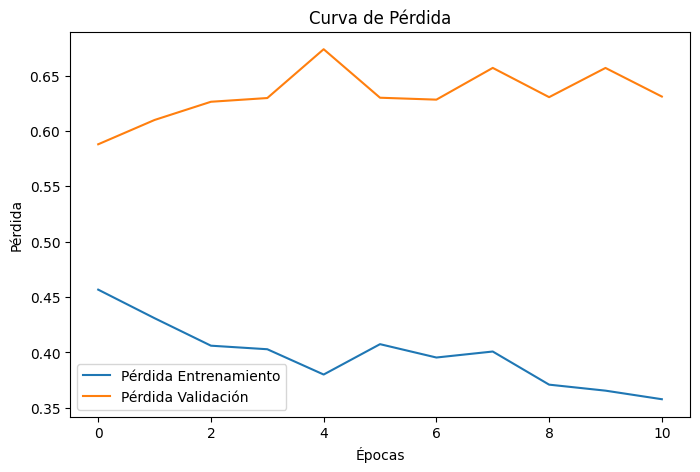

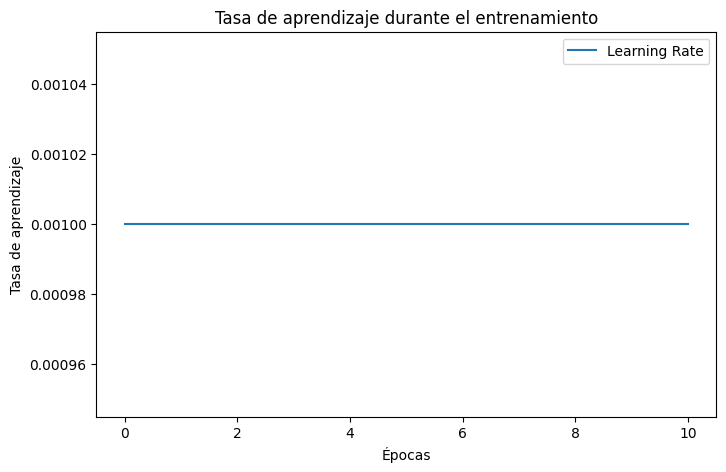

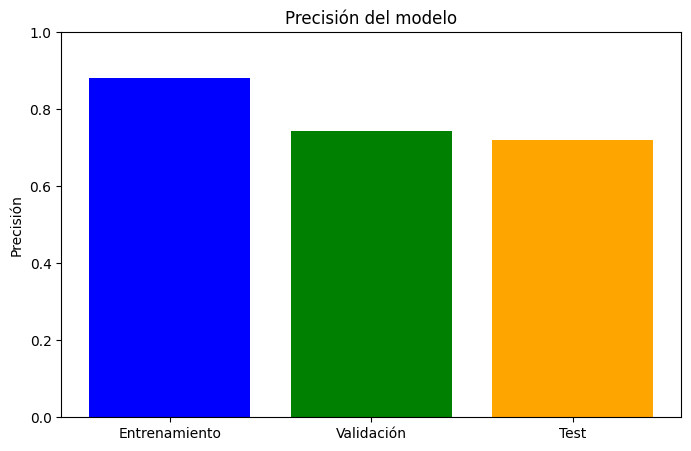

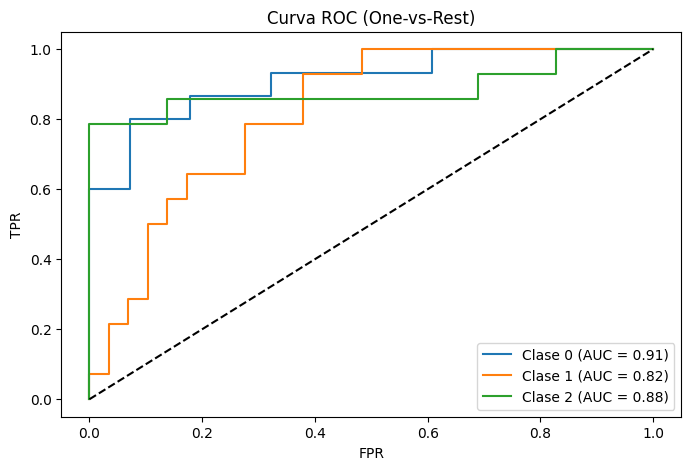

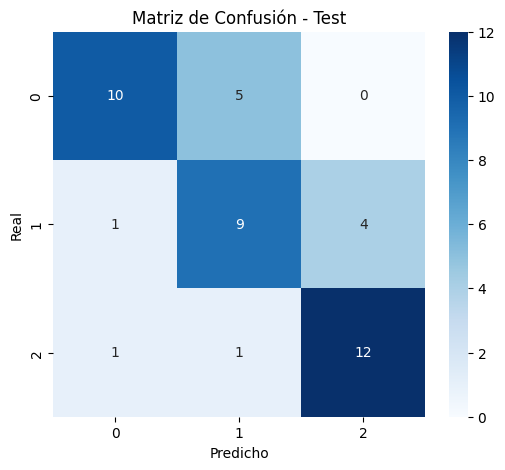

In [21]:

# =============================================================================
# 5. Generación de gráficos
# =============================================================================

# 5.1. Función de pérdida
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Pérdida Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida Validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Curva de Pérdida')
plt.legend()
plt.show()

# 5.2. Tasa de aprendizaje (se grafica como valor constante)
# En este caso usamos el valor inicial del optimizador
lr_value = best_model.optimizer.learning_rate.numpy()
plt.figure(figsize=(8, 5))
plt.plot(np.arange(len(history.history['loss'])), [lr_value] * len(history.history['loss']), label='Learning Rate')
plt.xlabel('Épocas')
plt.ylabel('Tasa de aprendizaje')
plt.title('Tasa de aprendizaje durante el entrenamiento')
plt.legend()
plt.show()

# 5.3. Precisión del modelo en Entrenamiento, Validación y Test
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
plt.figure(figsize=(8, 5))
plt.bar(['Entrenamiento', 'Validación', 'Test'], [train_acc, val_acc, test_accuracy], color=['blue', 'green', 'orange'])
plt.ylabel('Precisión')
plt.title('Precisión del modelo')
plt.ylim([0, 1])
plt.show()

# 5.4. Curva ROC para cada clase (One-vs-Rest)
# Binarizar las etiquetas verdaderas
y_test_bin = label_binarize(y_test_labels, classes=[0, 1, 2])
plt.figure(figsize=(8, 5))
for i in range(3):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {i} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC (One-vs-Rest)')
plt.legend()
plt.show()

# 5.5. Matriz de confusión
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.title(title)
    plt.show()

plot_conf_matrix(y_test_labels, y_pred, 'Matriz de Confusión - Test')


#Red neuronal con mala función de pérdida

##Modelo y entrenamiento

In [22]:
from sklearn.neural_network import MLPRegressor

# -----------------------------------------------------------------------------
# Configuración del modelo "mal configurado"
# -----------------------------------------------------------------------------
# Usamos MLPRegressor para resolver un problema de clasificación, lo cual significa
# que se usará el error cuadrático medio (MSE) como función de pérdida (incorrecto)
# y configuramos un learning_rate_init muy alto.
bad_mlp = MLPRegressor(
    hidden_layer_sizes=(50, 50, 50),  # Más de una capa oculta
    activation='logistic',           # Función de activación para las capas ocultas
    solver='sgd',                    # Descenso de gradiente estocástico
    learning_rate='constant',        # Tasa de aprendizaje constante
    learning_rate_init=1.0,          # Tasa de aprendizaje extremadamente alta
    max_iter=5000,
    alpha=0.01,
    random_state=42
)

# -----------------------------------------------------------------------------
# Entrenar el modelo "mal configurado"
# -----------------------------------------------------------------------------
bad_mlp.fit(X_train_scaled, y_train)

# -----------------------------------------------------------------------------
# Evaluación del modelo "mal configurado"
# -----------------------------------------------------------------------------
# Las salidas serán continuas. Convertimos las predicciones (que son vectores de 3 valores)
# a etiquetas mediante argmax.
y_pred_bad = bad_mlp.predict(X_test_scaled)
y_pred_bad_labels = np.argmax(y_pred_bad, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

accuracy_bad = accuracy_score(y_test_labels, y_pred_bad_labels)
print("Accuracy (modelo mal configurado):", accuracy_bad)
print(classification_report(y_test_labels, y_pred_bad_labels))

Accuracy (modelo mal configurado): 0.32558139534883723
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        15
           1       0.00      0.00      0.00        14
           2       0.33      1.00      0.49        14

    accuracy                           0.33        43
   macro avg       0.11      0.33      0.16        43
weighted avg       0.11      0.33      0.16        43



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##Gráficos

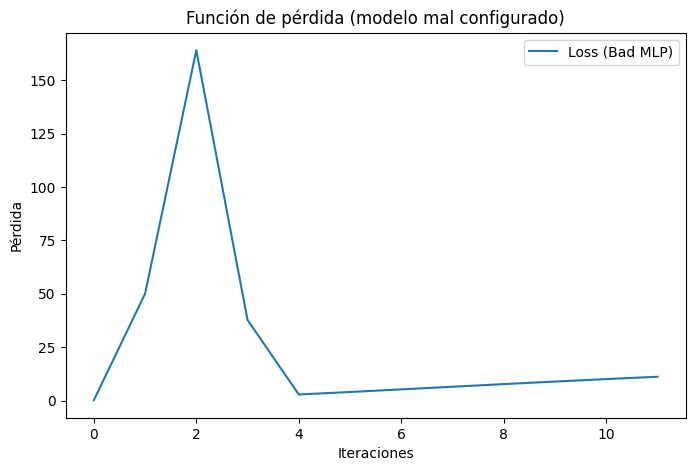

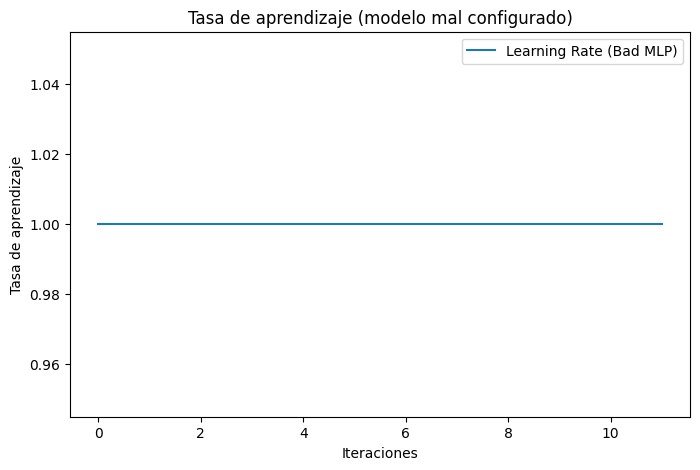

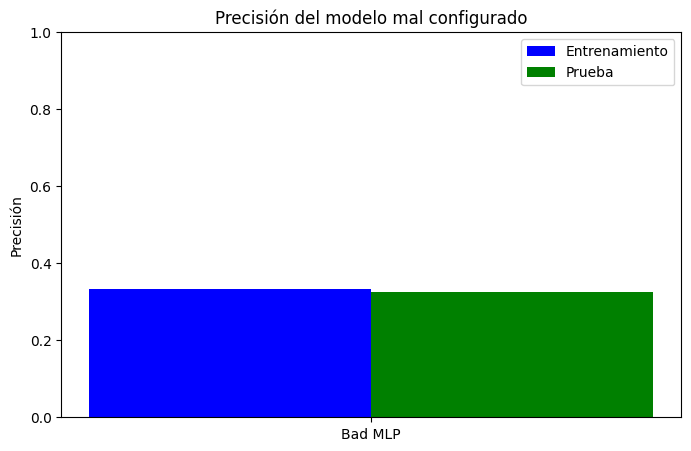

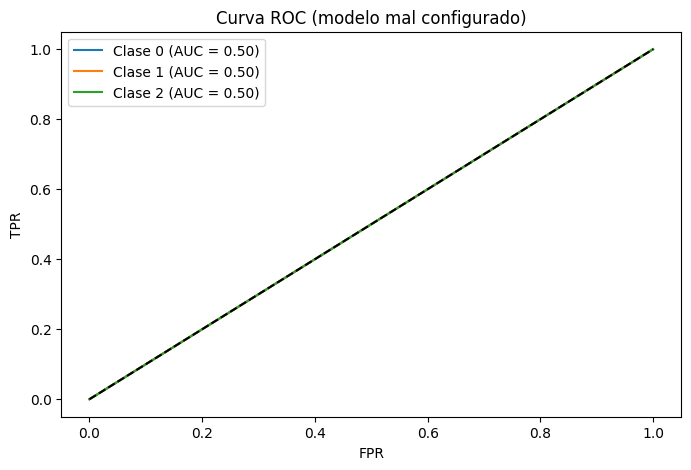

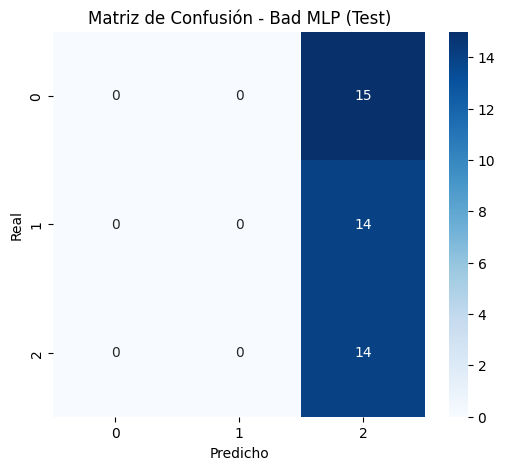

In [23]:
# 1. Función de pérdida
plt.figure(figsize=(8, 5))
if hasattr(bad_mlp, 'loss_curve_') and bad_mlp.loss_curve_:
    plt.plot(bad_mlp.loss_curve_, label='Loss (Bad MLP)')
    plt.xlabel('Iteraciones')
    plt.ylabel('Pérdida')
    plt.title('Función de pérdida (modelo mal configurado)')
    plt.legend()
    plt.show()
else:
    print("El modelo mal configurado no tiene 'loss_curve_' disponible.")

# 2. Tasa de aprendizaje (se muestra como valor constante a lo largo de las iteraciones)
plt.figure(figsize=(8, 5))
lr_bad = bad_mlp.learning_rate_init
if hasattr(bad_mlp, 'loss_curve_') and bad_mlp.loss_curve_:
    plt.plot(np.arange(len(bad_mlp.loss_curve_)), [lr_bad] * len(bad_mlp.loss_curve_), label='Learning Rate (Bad MLP)')
    plt.xlabel('Iteraciones')
    plt.ylabel('Tasa de aprendizaje')
    plt.title('Tasa de aprendizaje (modelo mal configurado)')
    plt.legend()
    plt.show()
else:
    print("El modelo mal configurado no tiene 'loss_curve_' para graficar la tasa de aprendizaje.")

# 3. Precisión del modelo (Entrenamiento y Prueba)
# Para el conjunto de entrenamiento:
y_train_pred_bad = bad_mlp.predict(X_train_scaled)
y_train_pred_bad_labels = np.argmax(y_train_pred_bad, axis=1)
y_train_labels = np.argmax(y_train, axis=1)
train_acc_bad = accuracy_score(y_train_labels, y_train_pred_bad_labels)
test_acc_bad = accuracy_score(y_test_labels, y_pred_bad_labels)

plt.figure(figsize=(8, 5))
models = ['Bad MLP']
train_accs = [train_acc_bad]
test_accs = [test_acc_bad]
x = np.arange(len(models))
width = 0.35

plt.bar(x - width/2, train_accs, width, label='Entrenamiento', color='blue')
plt.bar(x + width/2, test_accs, width, label='Prueba', color='green')
plt.xticks(x, models)
plt.ylabel('Precisión')
plt.title('Precisión del modelo mal configurado')
plt.ylim([0, 1])
plt.legend()
plt.show()

# 4. Curva ROC para cada clase (One-vs-Rest)
# MLPRegressor no ofrece predict_proba, así que aplicamos softmax manualmente
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return e_x / e_x.sum(axis=1, keepdims=True)

y_pred_bad_softmax = softmax(y_pred_bad)

plt.figure(figsize=(8, 5))
# Binarizar las etiquetas verdaderas para ROC (One-vs-Rest)
y_test_bin = label_binarize(y_test_labels, classes=[0, 1, 2])
for i in range(3):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_bad_softmax[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Clase {i} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC (modelo mal configurado)')
plt.legend()
plt.show()

# 5. Matriz de Confusión
def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
    plt.xlabel('Predicho')
    plt.ylabel('Real')
    plt.title(title)
    plt.show()

plot_conf_matrix(y_test_labels, y_pred_bad_labels, 'Matriz de Confusión - Bad MLP (Test)')

#Exportación modelos

In [24]:
import joblib
import os

# Crear carpeta de exportación (si no existe)
export_dir = 'saved_models'
if not os.path.exists(export_dir):
    os.makedirs(export_dir)

# Exportar modelos de scikit-learn usando joblib
joblib.dump(perceptron, os.path.join(export_dir, 'perceptron_model.pkl'))
joblib.dump(best_mlp, os.path.join(export_dir, 'best_mlp_model.pkl'))
joblib.dump(bad_mlp, os.path.join(export_dir, 'bad_mlp_model.pkl'))

print("Modelos de scikit-learn exportados correctamente.")

# Exportar el modelo de TensorFlow usando la extensión .keras para el formato nativo
tf_model_path = os.path.join(export_dir, 'best_tf_model.keras')
best_model.save(tf_model_path)
print("Modelo de TensorFlow exportado correctamente en:", tf_model_path)


Modelos de scikit-learn exportados correctamente.
Modelo de TensorFlow exportado correctamente en: saved_models/best_tf_model.keras


#Análisis con Shap values

  0%|          | 0/1 [00:00<?, ?it/s]

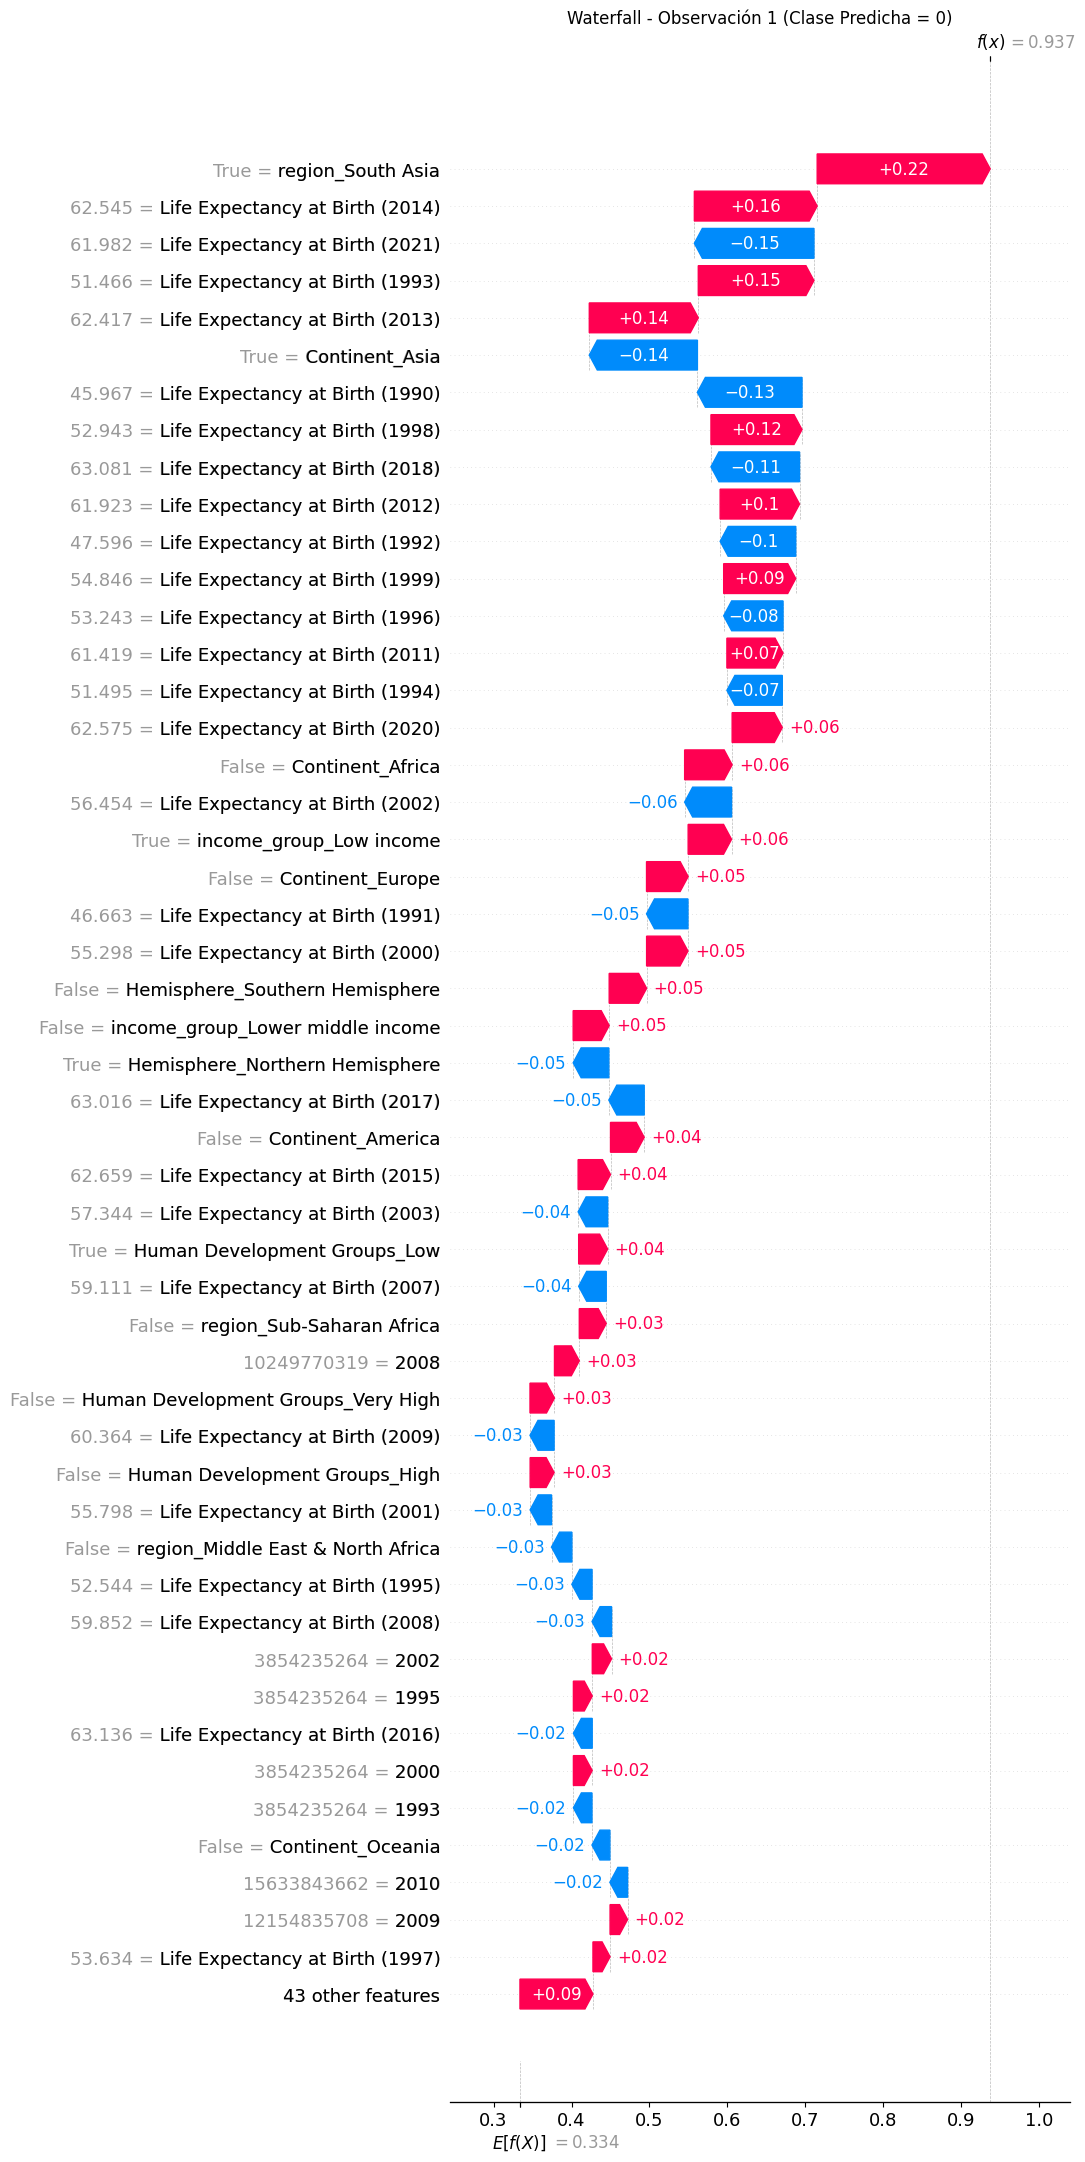

  0%|          | 0/1 [00:00<?, ?it/s]

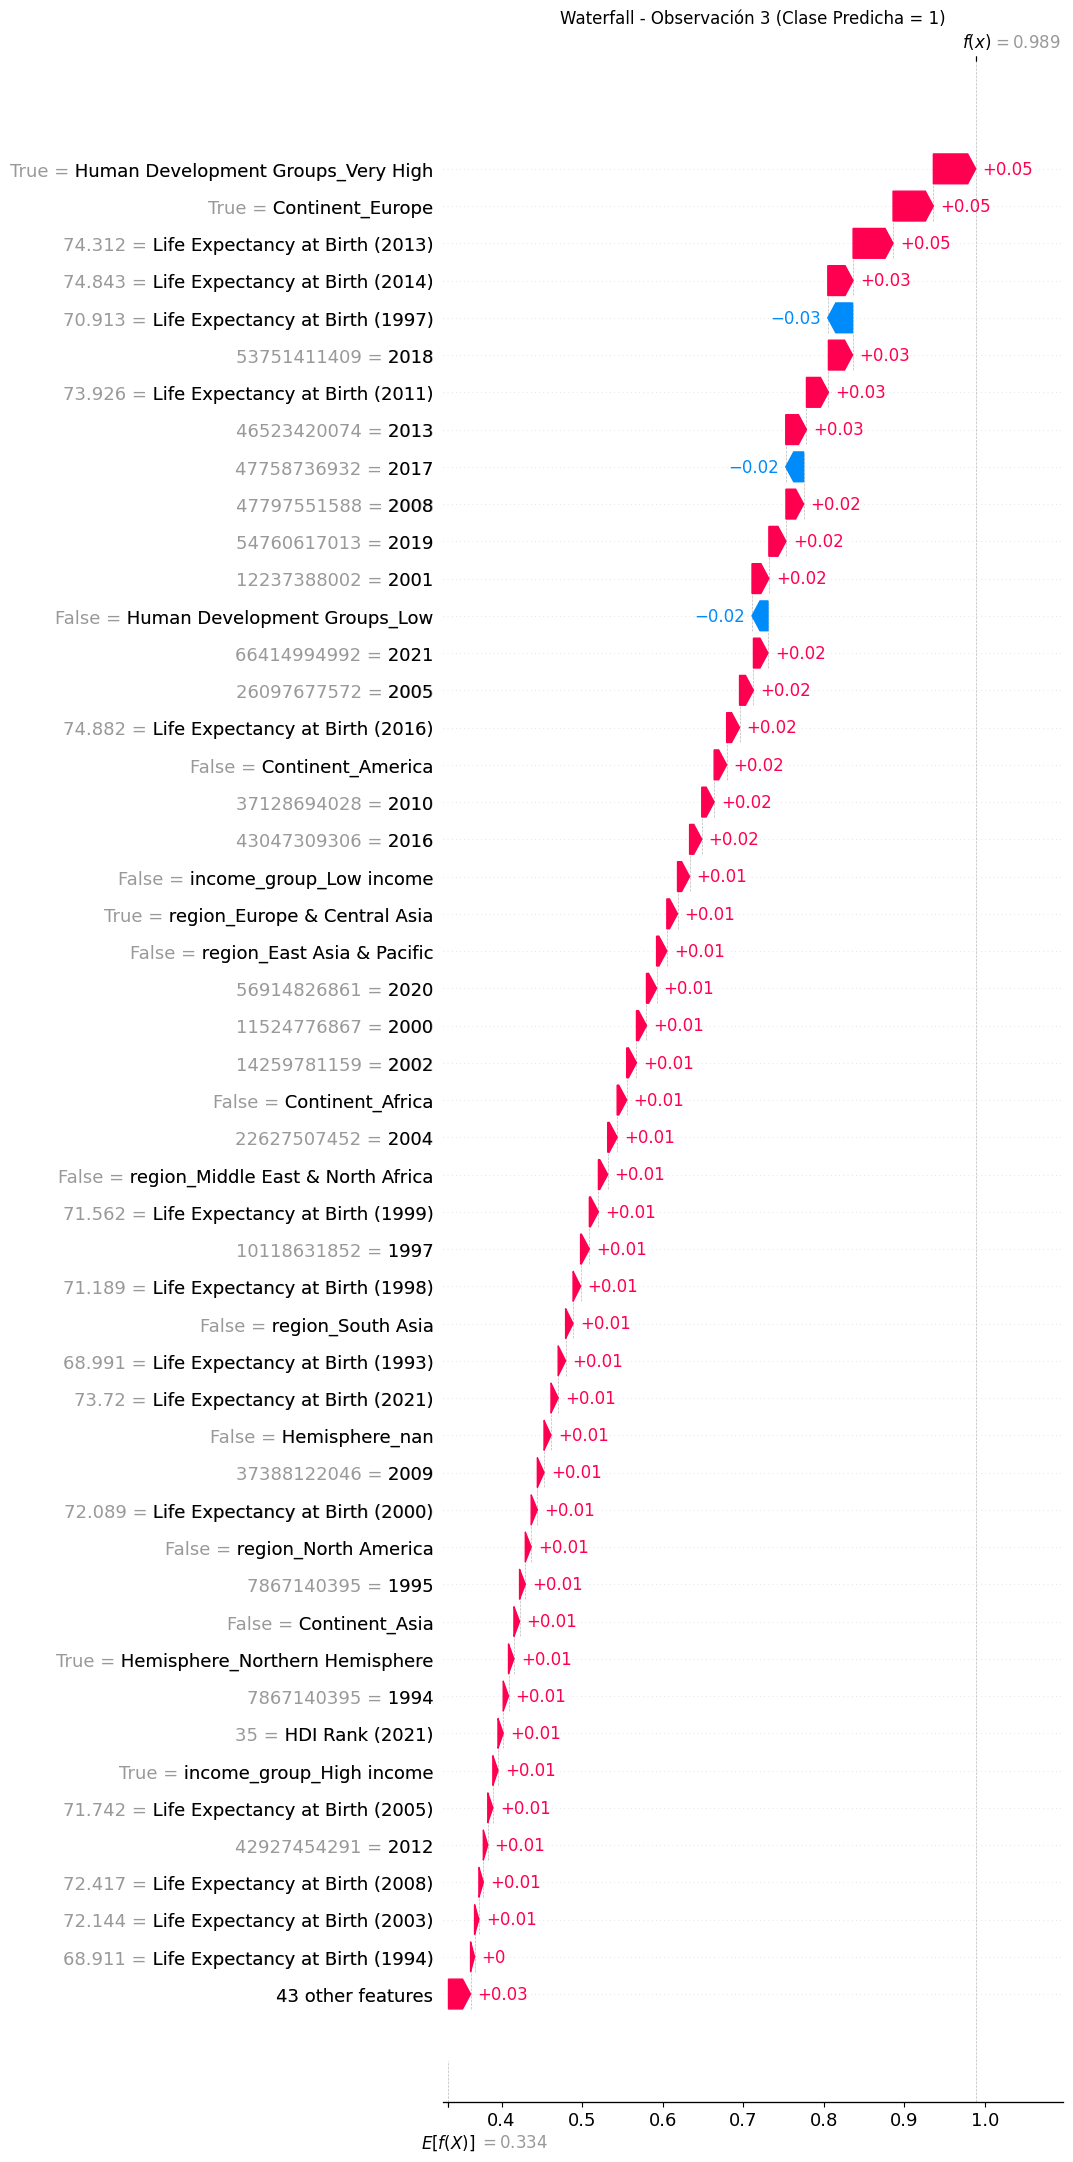

  0%|          | 0/1 [00:00<?, ?it/s]

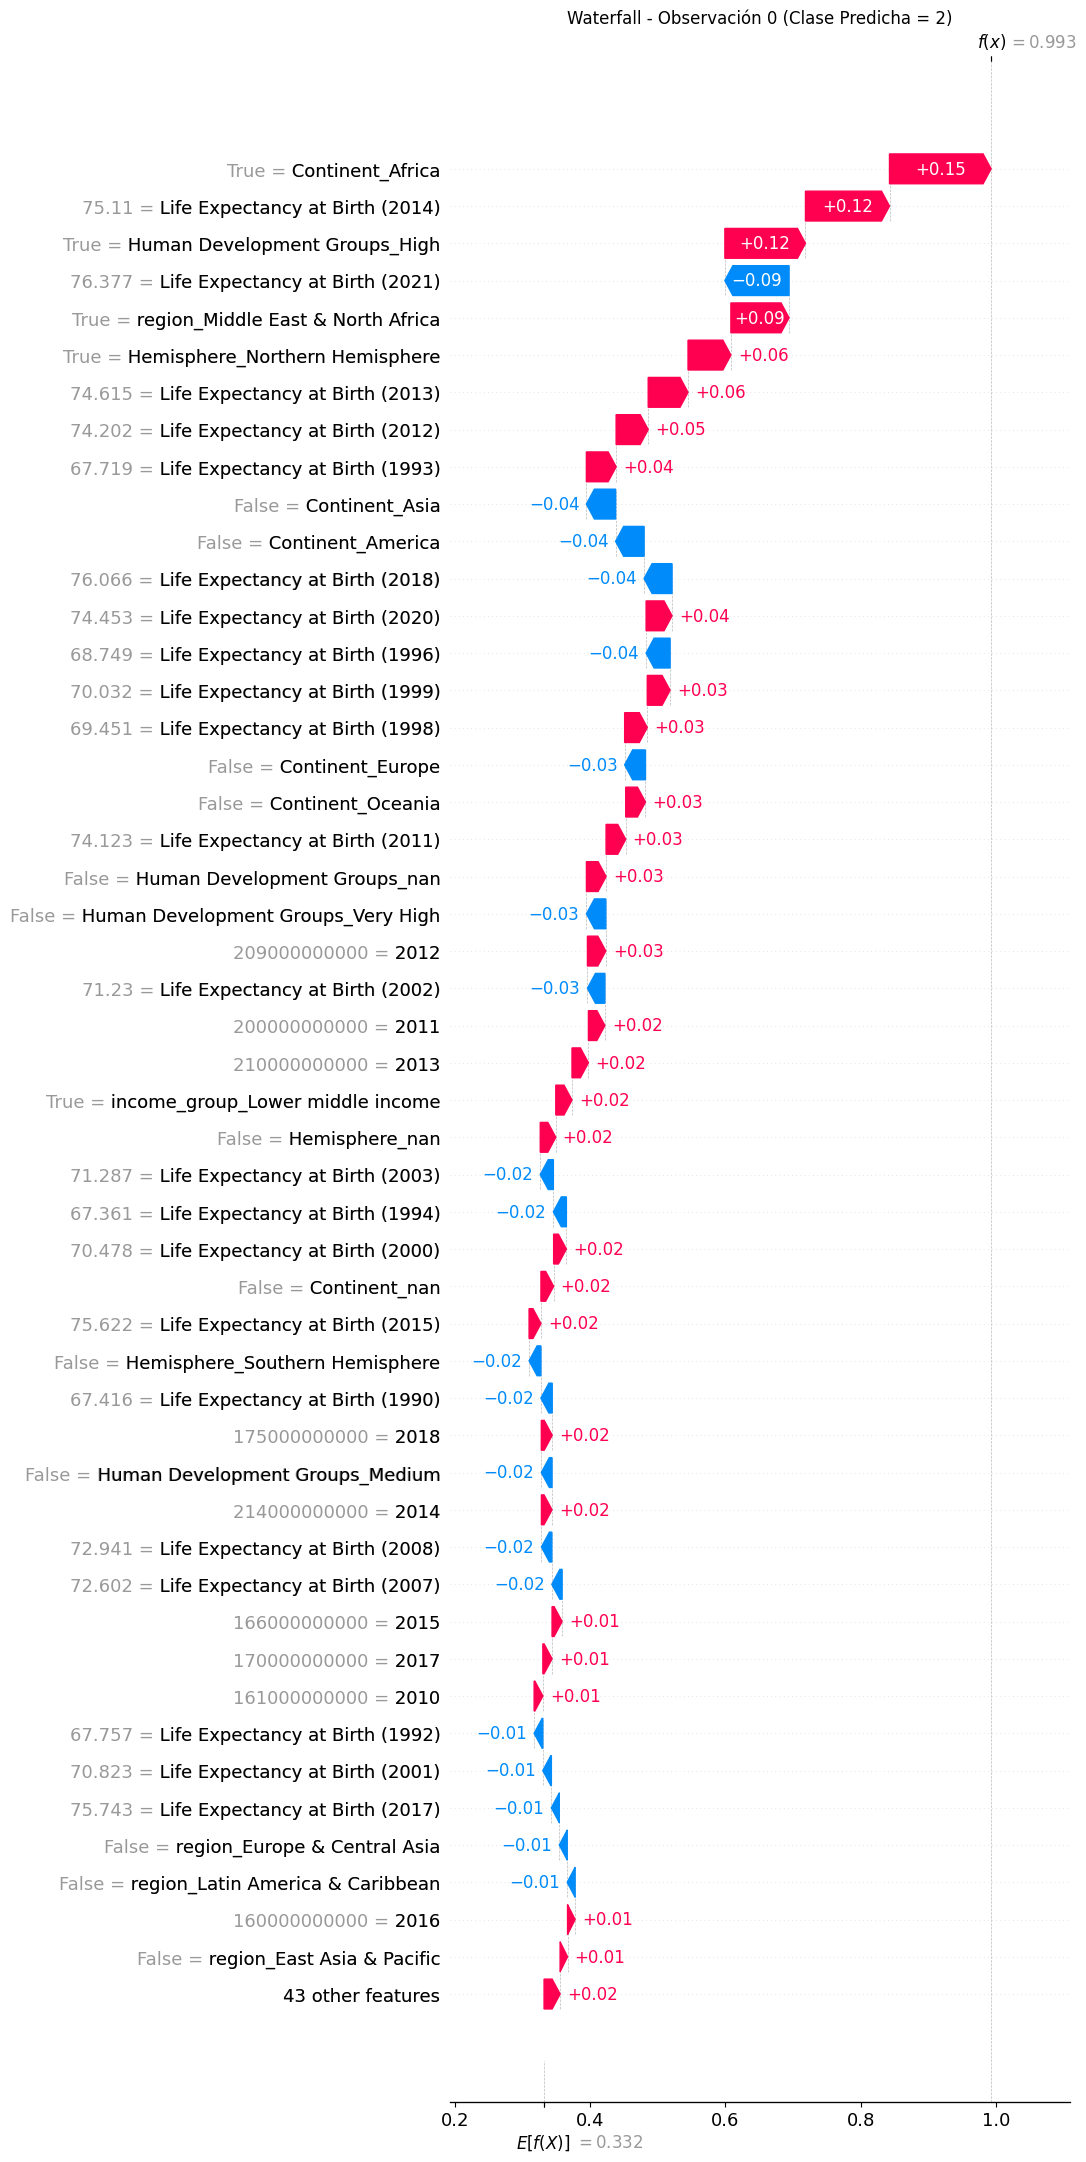

In [25]:
import numpy as np
import shap
import matplotlib.pyplot as plt

# 1) Calculamos las probabilidades de predicción para cada instancia
pred_proba = best_mlp.predict_proba(X_test_scaled)  # shape (n_muestras, 3)

# Definimos el explainer usando predict_proba para multiclase
explainer = shap.KernelExplainer(
    model=best_mlp.predict_proba,
    data=X_train_scaled
)
# 2) Buscamos un índice de observación para cada clase (0, 1, 2)
#    donde esa clase sea la de máxima probabilidad
class_indices = [None, None, None]  # Guardará el índice para cada clase
num_samples = len(X_test_scaled)

for i in range(num_samples):
    predicted_class = np.argmax(pred_proba[i])  # argmax de las 3 clases
    if class_indices[predicted_class] is None:
        class_indices[predicted_class] = i
    # Si ya encontramos índices para las 3 clases, salimos
    if all(x is not None for x in class_indices):
        break

# Verificamos que realmente se haya encontrado al menos una muestra para cada clase
if any(x is None for x in class_indices):
    raise ValueError("No se encontró al menos una instancia para cada clase en las predicciones.")

# 3) Para cada clase (0, 1, 2), generamos el waterfall plot
for class_idx in [0, 1, 2]:
    row_idx = class_indices[class_idx]  # La observación donde la clase_idx es la más probable

    # Extraemos la fila escalada para esa observación
    X_instance = X_test_scaled[row_idx:row_idx+1]  # shape (1, n_features)

    # Calculamos los SHAP values para esa instancia
    shap_values_single = explainer.shap_values(X_instance)
    # En multiclase con KernelExplainer, shap_values_single[0] suele ser de shape (n_features, 3)
    shap_values_matrix = shap_values_single[0]

    # Extraemos la columna de contribuciones para la clase class_idx (forma (n_features,))
    feature_contributions = shap_values_matrix[:, class_idx]

    # Tomamos el base value para esa clase
    base_value = explainer.expected_value[class_idx]

    # Creamos el waterfall plot
    fig = shap.waterfall_plot(
        shap.Explanation(
            base_values=base_value,
            values=feature_contributions,
            feature_names=X_test.columns,   # Ajusta si X_test es un DataFrame con nombres
            data=X_test.iloc[row_idx],      # Valores originales (opcional pero útil)
        ),
        max_display=50,  # Ajusta según la cantidad de columnas que quieras ver
        show=False
    )

    plt.title(f"Waterfall - Observación {row_idx} (Clase Predicha = {class_idx})")
    plt.show()
